In [1]:
# Import numpy library for use in ...
import numpy as np

amino_acids = {
    "A":0, "R":1, "N":2, "D":3, "C":4, "Q":5, "E":6, "G":7, "H":8, "I":9, "L":10, "K":11, "M":12, "F":13, "P":14, "S":15, "T":16, "W":17, "Y":18, "V":19
}

VHSE_descriptors = {
    0:{"A":0.15, "R":-1.47, "N":-0.99, "D":-1.15, "C":0.18, "Q":-.96, "E":-1.18, "G":-0.2, "H":-0.43, "I":1.27, "L":11.36, "K":-1.17, "M":1.01, "F":1.52, "P":0.22, "S":-0.67, "T":-0.34, "W":1.5, "Y":0.61, "V":0.76},
    1:{"A":-1.11, "R":1.45, "N":0,     "D":0.67, "C":-1.67, "Q":0.12, "E":0.4, "G":-1.53, "H":-0.25, "I":-0.14, "L":0.07, "K":0.7, "M":-0.53, "F":0.61, "P":-0.17, "S":-0.86, "T":-0.51, "W":2.06, "Y":1.6, "V":-0.92},
    2:{"A":-1.35, "R":1.24, "N":-0.37, "D":-0.41, "C":-0.46, "Q":0.18, "E":0.1, "G":-2.63, "H":0.37, "I":0.3, "L":0.26, "K":0.7, "M":0.43, "F":0.96, "P":-0.5, "S":-1.07, "T":-0.55, "W":1.79, "Y":1.17, "V":0.17},
    3:{"A":-0.92, "R":1.27, "N":0.69, "D":-0.01, "C":-.021, "Q":0.16, "E":0.36, "G":2.28, "H":0.19, "I":-1.8, "L":-0.8, "K":0.8, "M":0, "F":-0.16, "P":0.05, "S":-0.41, "T":-1.06, "W":0.75, "Y":0.73, "V":-1.91},
    4:{"A":0.02, "R":1.55, "N":-0.55, "D":-2.68, "C":0, "Q":0.09, "E":-2.16, "G":-0.53, "H":0.51, "I":0.3, "L":0.22, "K":1.64, "M":0.23, "F":0.25, "P":-0.01, "S":-0.32, "T":0.01, "W":0.75, "Y":0.53, "V":0.22},
    5:{"A":-0.91, "R":1.47, "N":0.85, "D":1.31, "C":1.2, "Q":0.42, "E":-0.17, "G":-1.18, "H":1.28, "I":-1.61, "L":-1.37, "K":0.67, "M":0.1, "F":0.28, "P":-1.43, "S":0.27, "T":-0.01, "W":-0.13, "Y":0.25, "V":-1.4},
    6:{"A":0.36, "R":1.3, "N":0.73, "D":0.03, "C":-1.61, "Q":-0.2, "E":0.91, "G":2.01, "H":0.93, "I":-0.16, "L":0.08, "K":1.63, "M":-0.86, "F":-1.33, "P":-0.19, "S":-0.64, "T":-0.79, "W":-1.06, "Y":-0.96, "V":-0.24},
    7:{"A":-0.48, "R":0.83, "N":-0.8, "D":0.56, "C":-0.19, "Q":-0.41, "E":0.02, "G":-1.34, "H":0.65, "I":-0.13, "L":-0.62, "K":0.13, "M":-0.68, "F":-0.2, "P":3.56, "S":0.11, "T":0.39, "W":-0.85, "Y":-0.52, "V":-0.03}
}

# Function info here ...
def import_fa(file_name, return_labels=False):
    print("Importing "+file_name)
    # List storage for file contents (sequences) and sequene labels
    sequences = []
    labels = []
    num_classes = 0
    class_counts = [0]
    # Try to open the file as read only
    try:
        file = open(file_name, "r")
    # If the file would not open, print error message and exit
    except:
        print("\nError: Could not open file")
        print("File name given: "+file_name+"\n")
        raise SystemExit
    # Iterate over all the lines in the file
    for line in file.readlines():
        # If this character is at the start of the line, it is a sequence label
        if line[0] == ">":
            # If the argument 'return_labels' is True, append the label to a list
            if return_labels:
                labels.append(str(line)[1:-1])
            else:
                continue
        elif "class" in line:
            class_counts.append(0)
            num_classes += 1
        else:
            class_counts[num_classes] += 1
        # Append the sequence to the list of sequences
        sequences.append(str(line)[:-1])
    print("    "+str(num_classes)+" classes")
    print("    "+str(len(sequences)-num_classes)+" sequences")
    print("    "+str(np.array(class_counts)[1:])+" class counts")
    # If the argument 'return_labels' is True, return arrays of the sequences and labels
    if return_labels:
        return np.array(sequences), np.array(labels)
    # If False, only return an array of the sequences
    else:
        return np.array(sequences)

# Function info here ...
def raw_to_features(data,resample=1.0,balance=False):
    print("\nConverting to features:")
    num_VHSE = len(VHSE_descriptors)
    num_AA = len(amino_acids)
    num_features = num_AA + num_VHSE
    n = len(data)
    # Find basic data stats for function use:
    #   the max length sequence in the data
    #   the number of classes
    #   count of each class
    max_seq_len = 0
    class_counts = [0]
    num_classes = -1
    # Iterate over all sequences to count num classes, class frequencies, and the max sequence length
    for line in data:
        # Look out for a new class
        if "class" in line:
            class_counts.append(0)
            num_classes += 1
            continue
        # Skip labels
        elif line[0] == ">":
            continue
        # Update max sequence length
        if len(line) > max_seq_len:
            max_seq_len = len(line)
        # Update class counts
        class_counts[num_classes+1] += 1
    
    # Since this was -1 based, increment to convert to 0 based count
    num_classes += 1
    n -= num_classes
    
    # Print stats found above
    print("  Num Classes:", num_classes)
    print("  Class Counts:")
    frmt = "{:>7}"*num_classes
    print(" "+frmt.format(*[i for i in range(num_classes)]))
    print("   ",end="")
    frmt = "{:>7}"*num_classes
    print(" "+frmt.format(*[class_counts[i] for i in range(1,num_classes+1)]))

    # Split data by class for resampling
    data_by_class = []
    start_idx = 1
    end_idx = start_idx + class_counts[1]
    for i in range(num_classes):
        new_class = data[start_idx+1:end_idx]
        np.random.shuffle(new_class)
        data_by_class.append( new_class )
        if i < num_classes-1:
          #print(start_idx, end_idx, class_counts[i+2], class_counts)
          start_idx += end_idx
          end_idx = start_idx + class_counts[i+2]

    #print("data by class:",data_by_class)

    # Init variables for resampling
    total_per_class = 0
    num_samples = n
    # If resampling:
    if resample != 1.0:
        # Calculate the size of the resampled dataset
        num_samples = int(n*resample)
        # If balanced classs coutns are required:
        if balance:
            # Calculate a balanced total number of instances per class
            total_per_class = int(num_samples/num_classes)
            if total_per_class > min(np.array(class_counts)[1:]):
                total_per_class = min(np.array(class_counts)[1:])
            #print("\ntotal/class:", total_per_class, "\n")
            for i in range(len(data_by_class)):
                indexes = np.random.default_rng().choice(len(data_by_class[i]), size=total_per_class-1, replace=False)
                #print("idxs:",indexes)
                data_by_class[i] = data_by_class[i][indexes]
            
        # If imbalanced class counts are acceptable
        else:
            # Calculate the total number of instances per class in the same ratio as class counts
            total_per_class = [int(num_samples*class_counts[i+1]/n) for i in range(num_classes)]
            #print("total/class:",total_per_class)
            for i in range(len(data_by_class)):
                indexes = np.random.default_rng().choice(len(data_by_class[i]), size=total_per_class[i]-1, replace=False)
                data_by_class[i] = data_by_class[i][indexes]
            
        print("  Resampling:")
        print("    Dataset size :",n)
        print("    Total/class  :",total_per_class)
        print("    Total samples:",total_per_class*num_classes)
        print()
    # If not resampling
    # TODO:  Complete - could the above be used instead of conditional?
    else:
        total_per_class = int(n/num_classes)
    
    #print("data by class:",data_by_class)
    
    # Instantiate storage of features and labels
    X = []
    y = []
      
    # Convert from strings to arrays and pad the sequences with zeros to 
    # the length of the maximum length sequence; this is the number of features
    index = 0
    for i in range(len(data_by_class)):
        for j in range(len(data_by_class[i])):
            # Instantiate new array of zeros
            new_instance = []
            for k in range(num_VHSE):
                new_instance.append([-999 for acid in range(max_seq_len)])
            for k in range(num_AA):
                new_instance.append([0 for acid in range(max_seq_len)])
            # Fill in sequence
            for k in range(len(data_by_class[i][j])):
                acid_char = data_by_class[i][j][k]
                if acid_char in amino_acids:
                    for l in range(num_VHSE):
                        new_instance[l][k] = VHSE_descriptors[l][acid_char]
                    new_instance[amino_acids[acid_char]+num_VHSE][k] = 1
            # Store new sequence in features store X
            X.append(new_instance)
            y.append(i)
            index += 1

    # Return features and labels
    return np.array(X),np.array(y),max_seq_len

In [2]:
# For one-hot encoding
from tensorflow.keras.utils import to_categorical
# For the loss function and optimizer
import tensorflow.keras as keras
# For the model
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.layers import LeakyReLU

2021-12-14 14:37:16.054459: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-14 14:37:16.054484: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# Import the data and extract features
import time
start = time.time()
data = import_fa("data/ubl_zinc.fa")
X, y, seq_len = raw_to_features(data, resample=0.3, balance=True)
end = time.time()

print("Time taken:", round(end-start,3),"sec")
print("shape of X:",np.shape(X))
print("shape of y:",np.shape(y))

Importing data/ubl_zinc.fa
    2 classes
    29800 sequences
    [ 3740 26060] class counts

Converting to features:
  Num Classes: 2
  Class Counts:
       0      1
       3740  26060
  Resampling:
    Dataset size : 29800
    Total/class  : 3740
    Total samples: 7480

Time taken: 176.595 sec
shape of X: (7478, 28, 5537)
shape of y: (7478,)


In [4]:
# Convert y to one-hot encoding for the CNN 
y_one_hot = to_categorical(y)

# Split the data into train, test, and validation
from sklearn.model_selection import train_test_split
X, valid_X, y_one_hot, valid_y = train_test_split(X, y_one_hot, test_size=0.2, random_state=0)
train_X, test_X, train_y, test_y = train_test_split(X, y_one_hot, test_size=0.2, random_state=0)


In [5]:

train_class_counts = [0,0]
for i in range(len(y_one_hot)):
  for j in range(len(y_one_hot[0])):
    if y_one_hot[i][j]==1:
      train_class_counts[j] += 1
valid_class_counts = [0,0]
for i in range(len(valid_y)):
  for j in range(len(valid_y[0])):
    if valid_y[i][j]==1:
      valid_class_counts[j] += 1

# Number of data instances
n = len(train_X)
# Number of features
m = len(train_X[0])
# Length of sequence
o = len(train_X[0][0])


In [6]:

# Print some data info
print("Shape of X      :",np.shape(X))
print("Shape of train_X:",np.shape(train_X))
print("Shape of valid_X:", np.shape(valid_X))
print()
print("Class distributions:")
print("  Train/Test:",train_class_counts)
print("  Validation:", valid_class_counts)
print()
print('n (no. train samples):',n)
print('m (num features)     :',m)
print('o (length of seqs)   :',o)

Shape of X      : (5982, 28, 5537)
Shape of train_X: (4785, 28, 5537)
Shape of valid_X: (1496, 28, 5537)

Class distributions:
  Train/Test: [3000, 2982]
  Validation: [739, 757]

n (no. train samples): 4785
m (num features)     : 28
o (length of seqs)   : 5537


In [7]:
# Some model parameters
batch_size = 64
epochs = 30
num_classes = 2

# Instantiate the model
model = Sequential()

# Add layers
model.add(Conv2D(filters=32, kernel_size=(m,3),activation='linear',input_shape=(m,o,1),padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=2,padding='same'))

model.add(Conv2D(filters=64, kernel_size=(1,3),activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=2,padding='same'))

model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
# For now, this gives errors about loading the dynamic library for GPU use
model.compile(
    loss=keras.losses.categorical_crossentropy, 
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy']
)

# Print a summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 5537, 32)      2720      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 5537, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 2769, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 2769, 64)      6208      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 2769, 64)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 1385, 64)      0         
 2D)                                                    

2021-12-14 14:40:18.146571: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-14 14:40:18.146898: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-14 14:40:18.146965: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2021-12-14 14:40:18.147020: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2021-12-14 14:40:18.147074: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [8]:
# Specify log files
#from datetime import datetime
#logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

# Train the model
history = model.fit(train_X, train_y, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(test_X, test_y))

2021-12-14 14:40:18.893031: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2967389040 exceeds 10% of free system memory.


Epoch 1/30


2021-12-14 14:40:20.616810: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1270054912 exceeds 10% of free system memory.
2021-12-14 14:40:21.894234: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1270054912 exceeds 10% of free system memory.


 1/75 [..............................] - ETA: 9:15 - loss: 6.4918 - accuracy: 0.5156

2021-12-14 14:40:27.799220: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1270054912 exceeds 10% of free system memory.
2021-12-14 14:40:29.047368: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1270054912 exceeds 10% of free system memory.


75/75 [==============================] - 567s 8s/step - loss: 1015.3623 - accuracy: 0.5223 - val_loss: 21.6769 - val_accuracy: 0.6366
Epoch 2/30
75/75 [==============================] - 567s 8s/step - loss: 30.3101 - accuracy: 0.6215 - val_loss: 6.9905 - val_accuracy: 0.7126
Epoch 3/30
75/75 [==============================] - 567s 8s/step - loss: 13.9567 - accuracy: 0.6627 - val_loss: 22.4612 - val_accuracy: 0.5990
Epoch 4/30
75/75 [==============================] - 568s 8s/step - loss: 18.1798 - accuracy: 0.6349 - val_loss: 4.8116 - val_accuracy: 0.7510
Epoch 5/30
75/75 [==============================] - 567s 8s/step - loss: 6.9161 - accuracy: 0.7367 - val_loss: 10.3651 - val_accuracy: 0.6901
Epoch 6/30
75/75 [==============================] - 568s 8s/step - loss: 6.6048 - accuracy: 0.7266 - val_loss: 3.0316 - val_accuracy: 0.8154
Epoch 7/30
75/75 [==============================] - 568s 8s/step - loss: 2.9251 - accuracy: 0.7994 - val_loss: 1.7531 - val_accuracy: 0.8429
Epoch 8/30
75/7

2021-12-14 19:27:32.945488: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: 21.12.13_model_ubl-zinc/assets


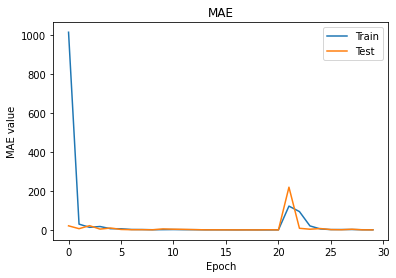

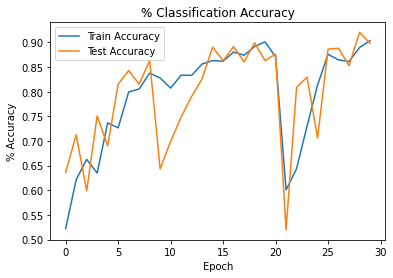

In [9]:
# Save the model
model.save("21.12.13_model_ubl-zinc")

# Print some of the results
import matplotlib.pyplot as plt
# Loss over epochs
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title('MAE')
plt.ylabel('MAE value')
plt.xlabel('Epoch')
plt.legend()
plt.show()
# Accuracy over epochs
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('% Classification Accuracy')
plt.ylabel('% Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [10]:
print("Number of validation samples:",len(valid_X))

# Evaluate the model with the final evaluation testing set
model.evaluate(valid_X, valid_y)

# Get predictions and print confusion matrix
results = model.predict(valid_X)

predictions = np.zeros(len(results))
observed = np.zeros(len(valid_y))

threshold = 0.5
for i in range(len(results)):
    if results[i][0] > threshold:
        predictions[i] = 0
    else:
        predictions[i] = 1
    if valid_y[i][1] == 1:
        observed[i] = 1

from sklearn.metrics import confusion_matrix

print( confusion_matrix(observed, predictions) )

Number of validation samples: 1496
47/47 [==============================] - 42s 899ms/step - loss: 1.3562 - accuracy: 0.8924
[[637 102]
 [ 59 698]]
